In [31]:
import pandas as pd
import numpy as np
from scipy import stats
from joblib import dump, load

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Sklearn imports
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# old classification metrics
from sklearn.metrics import ( classification_report, confusion_matrix, 
                             precision_score, accuracy_score, 
                             precision_recall_fscore_support )
# new classification metrics
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score


sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2})
#plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams.update({'font.size': 22})

In [34]:
def sort_creator(key=None,reverse=False,cmp=None):
    '''
        Create a custom sort function for a dataframe
        https://stackoverflow.com/questions/13838405/custom-sorting-in-pandas-dataframe
    '''
    def sorter(series):
        series_list = list(series)
        return [series_list.index(i) 
           for i in sorted(series_list,key=key,reverse=reverse,cmp=cmp)]
    return sorter

In [2]:
def get_metrics(confusion_matrix_file_name):
    '''
        read a confusion matrix from a file, and calculate some metrics
        input: a pd.DataFrame representing a confusion matrix
        output: a pd.DataFrame containing the metrics
    '''
    confusion_matrix = pd.read_csv(confusion_matrix_file_name)
    
    if 'Unnamed: 0' in confusion_matrix.columns:
        confusion_matrix.drop(columns=['Unnamed: 0'], inplace=True)
    
    confusion_matrix = confusion_matrix.values
    metrics = {}
    
    FP = metrics['False Positive'] = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = metrics['False Negative'] = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = metrics['True Positive'] = np.diag(confusion_matrix)
    TN = metrics['True Negative'] = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    metrics['True Positive Rate'] = TP/(TP+FN)
    # Specificity or true negative rate
    metrics['True Negative Rate'] = TN/(TN+FP) 
    # Precision or positive predictive value
    metrics['Precision'] = TP/(TP+FP)
    # Fall out or false positive rate ##########
    metrics['False Positive Rate (FAR)'] = FP/(FP+TN)
    # False negative rate ############
    metrics['False Negative Rate (FRR)'] = FN/(TP+FN)
    # Overall accuracy
    metrics['Overall Accuracy'] = (TP+TN)/(TP+FP+FN+TN)
    
    step = confusion_matrix_file_name.split('.')[0][-1]
    if step == "4":
        step = 'DETECT'
    else:
        step = f"Scenario {step}"
            
    metrics['Step'] = step
    
    #for metric, values in metrics.items():
    #print(f'{metric} has {len(values)} lines\n')
    
    metrics_df = pd.DataFrame(metrics)

    return metrics_df

In [3]:
metrics_step_1 = get_metrics('confusion_matrix_1.csv')
metrics_step_2 = get_metrics('confusion_matrix_2.csv')
metrics_step_3 = get_metrics('confusion_matrix_3.csv')
metrics_step_4 = get_metrics('confusion_matrix_4.csv')

/home/renato/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


In [36]:
# plot metrics here

## False Acceptance Rate

,False Positive Rate (FAR)
Step,
DETECT,0.000033
Scenario 1,0.000194
Scenario 2,0.000079
Scenario 3,0.000080


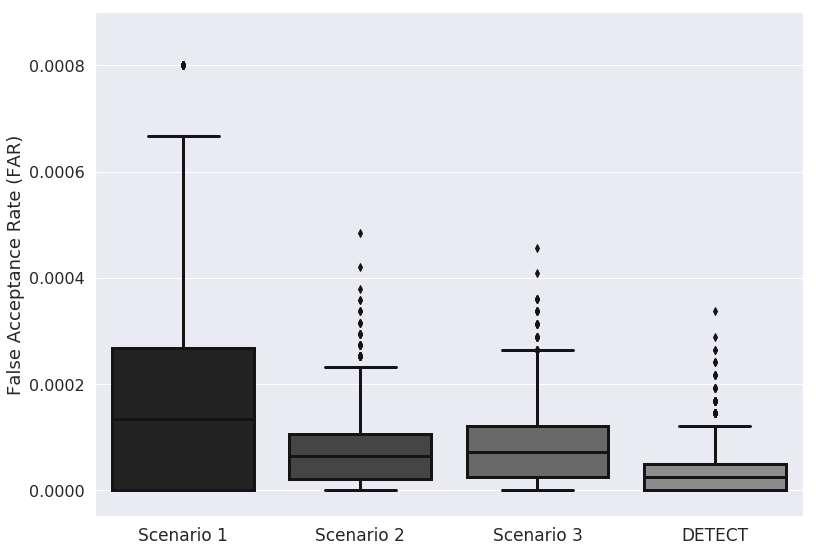

In [45]:
metric = 'False Positive Rate (FAR)'
far_columns = [metric,'Step'] 
far_data = pd.concat([
    metrics_step_1[far_columns],
    metrics_step_2[far_columns],
    metrics_step_3[far_columns],
    metrics_step_4[far_columns]
])

sns.set(rc={'figure.figsize':(12.7,9.27)})
plot = sns.boxplot( x=far_data["Step"], y=far_data[metric], linewidth=3, palette=sns.dark_palette("lightgrey"))

# y limit
plot.set(ylim=(-0.00005,0.0009)) # I'm hiding one Step 1 huge outlier so it does not completly mess the figure up

# labels
plot.set_ylabel("False Acceptance Rate (FAR)",fontsize=18)
plot.set_xlabel("")

# ticks
plot.set_yticklabels(['{:,.4f}'.format(x) for x in plot.get_yticks()], size=16)
plot.set_xticklabels(plot.get_xticklabels(), size = 17)

# save plot
plt.savefig('FAR_box_plot.eps')

# print mean values for each scenario
# mean values for each step
far_data.groupby('Step').mean()

## False Rejection Rate

,False Negative Rate (FRR)
Step,
DETECT,0.064003
Scenario 1,0.383813
Scenario 2,0.156959
Scenario 3,0.153801


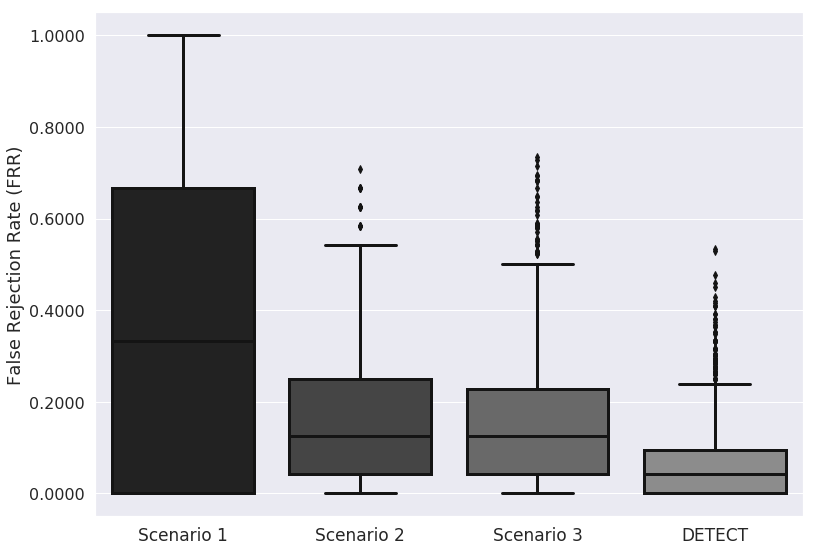

In [46]:
metric = 'False Negative Rate (FRR)'
frr_columns = [metric,'Step'] 
frr_data = pd.concat([
    metrics_step_1[frr_columns],
    metrics_step_2[frr_columns],
    metrics_step_3[frr_columns],
    metrics_step_4[frr_columns]
])

sns.set(rc={'figure.figsize':(12.7,9.27)})
plot = sns.boxplot( x=frr_data["Step"], y=frr_data[metric], linewidth=3, palette=sns.dark_palette("lightgrey"))

# y limit

# labels
plot.set_ylabel('False Rejection Rate (FRR)',fontsize=18)
plot.set_xlabel("")

# ticks
plot.set_yticklabels(['{:,.4f}'.format(x) for x in plot.get_yticks()], size=16)
plot.set_xticklabels(plot.get_xticklabels(), size = 17)

# save plot
plt.savefig('FRR_box_plot.eps')

# print mean value for each step
# mean values for each step
frr_data.groupby('Step').mean()

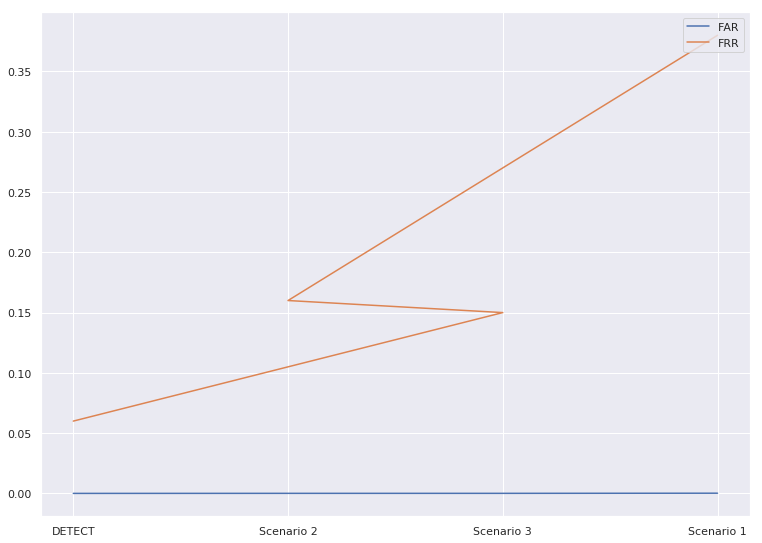

In [77]:
far_mean = far_data.groupby('Step').mean().sort_values(by=['False Positive Rate (FAR)'], ascending=True)
frr_mean = frr_data.groupby('Step').mean().sort_values(by=['False Negative Rate (FRR)'], ascending=True)

frr_mean = frr_mean.round(2)

plt.plot(far_mean, label='FAR')
plt.plot(frr_mean, label='FRR')
plt.legend(loc="upper right")

,False Negative Rate (FRR)
Step,
Scenario 1,0.4
Scenario 2,0.2
Scenario 3,0.2
DETECT,0.1


In [8]:
def get_roc_auc_score(y_test, probabilities):
    '''
        Calculate 4 different averages for the roc auc score
    '''
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#area-under-roc-for-the-multiclass-problem
    
    roc_auc = {}
    roc_auc['OVR Macro Average'] = roc_auc_score(y_test, probabilities, 
                                      multi_class="ovr", average="macro")
    roc_auc['OVR Weighted Average'] = roc_auc_score(y_test, probabilities, 
                                         multi_class="ovr", average="weighted")
    roc_auc['OVR Micro Average'] = roc_auc_score(y_test, probabilities, 
                                      multi_class="ovr", average="micro")
    roc_auc['OVR Samples Average'] = roc_auc_score(y_test, probabilities, 
                                         multi_class="ovr", average="samples")

    return roc_auc

In [ ]:
# save roc auc scores
roc_auc_step_1 = get_roc_auc_score(y_test_step_1, probabilities_step_1)
roc_auc_step_2 = get_roc_auc_score(y_test_step_2, probabilities_step_2)
roc_auc_step_3 = get_roc_auc_score(y_test_step_3, probabilities_step_3)
roc_auc_step_4 = get_roc_auc_score(y_test_step_4, probabilities_step_4)

# make a dataframe containing roc_auc_scores from all 4 steps
index = ['Step 1', 'Step 2', 'Step 3', 'DETECT']
roc_auc_scores_df = pd.Dataframe([roc_auc_step_1, roc_auc_step_2, roc_auc_step_3, roc_auc_step_4], index=index)

In [ ]:
#plot roc_auc_score here